In [2]:
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Путь к папке с данными
data_dir = "D:\\archive\\Train"  # Замените на свой путь

# Параметры
target_size = (64, 64)  # Размер изображений = 1   # 10% данных

# Создаем списки для хранения данных
images = []
labels = []

# Проходим по всем подпапкам (классам)
for class_id in tqdm(os.listdir(data_dir)):
    class_dir = os.path.join(data_dir, class_id)
    
    # Пропускаем файлы (если есть), работаем только с папками
    if not os.path.isdir(class_dir):
        continue
    
    # Получаем список всех изображений в классе
    all_images = os.listdir(class_dir)
    
    # Выбираем только часть изображений (10%)
    num_samples = int(len(all_images) * 1)
    sampled_images = np.random.choice(all_images, num_samples, replace=False)
    
    # Читаем выбранные изображения
    for img_name in sampled_images:
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:  # Проверка на успешное чтение
            img = cv2.resize(img, target_size)
            images.append(img)
            labels.append(int(class_id))

# Создаем датафрейм
df = pd.DataFrame({
    "image": images,
    "label": labels
})

# Проверяем датафрейм
print(df.head())
print(f"Всего изображений: {len(df)}")
print(f"Уникальных классов: {df['label'].nunique()}")

100%|██████████| 43/43 [04:33<00:00,  6.37s/it]


                                               image  label
0  [[[107, 112, 109], [105, 110, 110], [102, 107,...      0
1  [[[130, 140, 168], [145, 156, 184], [144, 159,...      0
2  [[[28, 21, 16], [29, 21, 16], [30, 20, 15], [3...      0
3  [[[67, 67, 64], [67, 67, 66], [66, 68, 69], [7...      0
4  [[[105, 107, 105], [105, 107, 105], [106, 107,...      0
Всего изображений: 39209
Уникальных классов: 43


In [3]:
'''Нормализация данных'''

df['image'] = df['image'].apply(lambda x: x / 255.0)  # [0, 1]

In [4]:
from sklearn.model_selection import train_test_split

X = np.stack(df['image'].values)  # Преобразуем список изображений в numpy-массив
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,  # 20% данных в тест
    random_state=42,
    stratify=y  # Сохраняет баланс классов
)

Epoch 1/20, Loss: 1.9658, Test Accuracy: 81.40%
Epoch 2/20, Loss: 0.7541, Test Accuracy: 92.96%
Epoch 3/20, Loss: 0.5071, Test Accuracy: 96.10%
Epoch 4/20, Loss: 0.3861, Test Accuracy: 97.45%
Epoch 5/20, Loss: 0.3136, Test Accuracy: 97.72%
Epoch 6/20, Loss: 0.2770, Test Accuracy: 98.21%
Epoch 7/20, Loss: 0.2418, Test Accuracy: 98.39%
Epoch 8/20, Loss: 0.2164, Test Accuracy: 98.78%
Epoch 9/20, Loss: 0.1900, Test Accuracy: 98.67%
Epoch 10/20, Loss: 0.1831, Test Accuracy: 98.52%
Epoch 11/20, Loss: 0.1614, Test Accuracy: 98.81%
Epoch 12/20, Loss: 0.1584, Test Accuracy: 98.94%
Epoch 13/20, Loss: 0.1436, Test Accuracy: 99.20%
Epoch 14/20, Loss: 0.1380, Test Accuracy: 98.83%
Epoch 15/20, Loss: 0.1308, Test Accuracy: 99.09%
Epoch 16/20, Loss: 0.1262, Test Accuracy: 99.07%
Epoch 17/20, Loss: 0.1143, Test Accuracy: 99.21%
Epoch 18/20, Loss: 0.1069, Test Accuracy: 99.31%
Epoch 19/20, Loss: 0.1123, Test Accuracy: 99.18%
Epoch 20/20, Loss: 0.1055, Test Accuracy: 99.18%
              precision    re

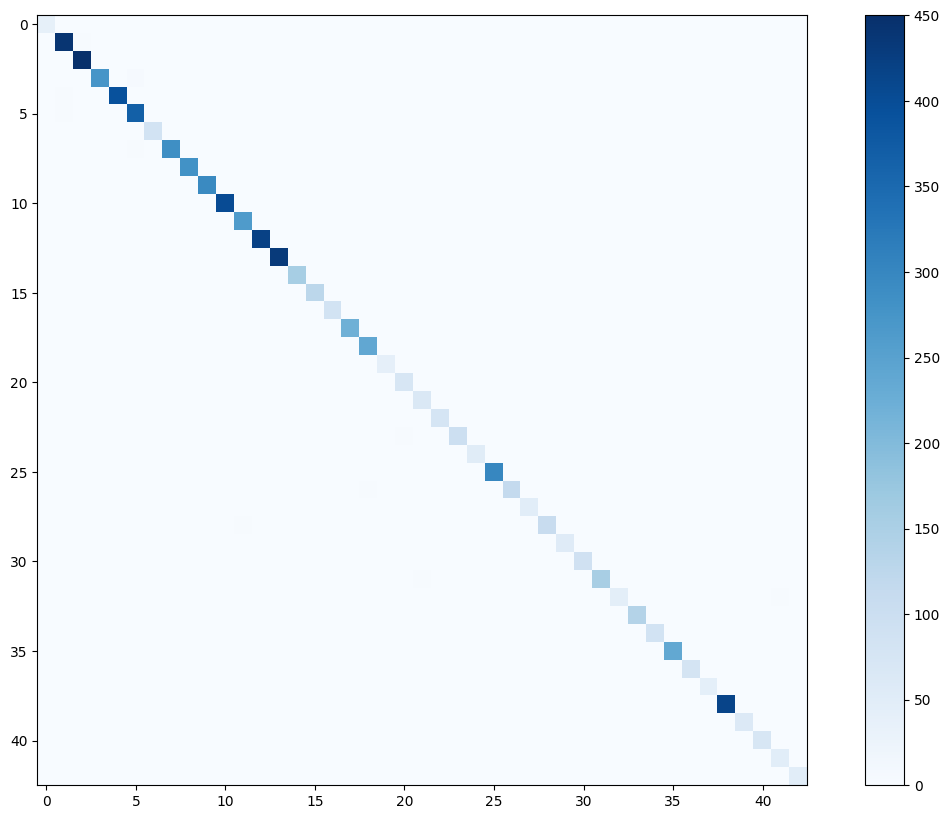

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# 1. Преобразование данных в тензоры PyTorch
X_train_tensor = torch.FloatTensor(X_train).permute(0, 3, 1, 2)  # [N, H, W, C] -> [N, C, H, W]
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test).permute(0, 3, 1, 2)
y_test_tensor = torch.LongTensor(y_test)

# 2. Создание DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 3. Определение модели CNN
class TrafficSignCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # [B, 3, 64, 64] -> [B, 32, 64, 64]
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> [B, 32, 32, 32]
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # -> [B, 64, 32, 32]
            nn.ReLU(),
            nn.MaxPool2d(2)  # -> [B, 64, 16, 16]
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  # [B, 64, 16, 16] -> [B, 64*16*16]
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 43)  # 43 класса
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model = TrafficSignCNN()

# 4. Настройка обучения
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 5. Функция обучения
def train_model(model, train_loader, test_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Валидация
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, '
              f'Test Accuracy: {100 * correct / total:.2f}%')

# 6. Запуск обучения
train_model(model, train_loader, test_loader, epochs=20)

# 7. Оценка модели
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.cpu().data, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())
    
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(15, 10))
    plt.imshow(cm, cmap='Blues')
    plt.colorbar()
    plt.show()

evaluate_model(model, test_loader)

# 8. Сохранение модели
torch.save(model.state_dict(), 'traffic_sign_cnn.pth')